## Step 0: Import Necessary Modules

In [1]:
import torch
import torchvision
import torchvision.transforms as transform
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from sklearn.model_selection import train_test_split

import torch.nn as nn
import torchvision.models as models
from torchvision.utils import make_grid
import torch.nn.functional as F
import time
import copy
import os
import cv2
from PIL import Image
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Step1: Data Preprocessing and Loading

In [13]:
simple_transform = transform.Compose([
                                      transform.RandomRotation(45),
                                      transform.RandomHorizontalFlip(p=0.5),
                                      transform.RandomVerticalFlip(p=0.5),
                                      transform.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.1),
                                      transform.RandomGrayscale(p=0.025),
                                      transform.Resize((220, 220)),
                                      transform.ToTensor(), 
                                      transform.Normalize((0.4124234616756439, 0.3674212694168091, 0.2578217089176178), 
                                                          (0.3268945515155792, 0.29282665252685547, 0.29053378105163574))])

In [ ]:
path = "/content/drive/MyDrive/22WINTER/596A/HW5/flower_train-1/flower_train"
original = ImageFolder(path, transform=simple_transform)
train, val = train_test_split(original, test_size=0.2, shuffle=True, random_state=43)

In [ ]:
# Number of workers enable parallel loading
bs = 16 # Batch size
loaders = {
    'train': DataLoader(train, batch_size=bs, num_workers=4, pin_memory=True),
    'val': DataLoader(val, batch_size=bs, num_workers=4, pin_memory=True),
}

dataset_sizes = {
    'train': len(train),
    'val': len(val)
}

## Step 2: Define the evaluation metrics(Accuracy)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1) 
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)), preds

##  Step 3: Training Pipeline 

In [ ]:
def train(epochs, model):
    """
    
    """
    ## Step 1: Send model to GPU device if GPU available, creating Loss function.
    print('Creating a model...')
    device= torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    if str(model) is 'resnet152':
      criterion = nn.NLLLoss()
      '''The last layer already has LogSoftmax(),
       so it cannot be calculated by nn.CrossEntropyLoss(). nn.CrossEntropyLoss() 
       is equivalent to the integration of logSoftmax() and nn.NLLLoss().'''
    else:
      criterion = nn.CrossEntropyLoss()
    
    ## Step 2: Create Optimizer, here we use pre-built and pretrained models like VGG-19, we use transfer
    ## learning so only train the classifier part or fully connected part while keeping the backbone of 
    ## the network weight fixed. Adam is the gradient descent algoritm we want to use as default.
    optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)

    since = time.time()
    best_model = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    
    ## Loop for train and val for every epoch
    for epoch in range(epochs):
        for phase in ['train', 'val']:
            
            ## Mode activation, before training network, you must call model.train(), before validation, you must call model.eval()
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0
            losses = {'train':[],'val':[]}
            accuracies = {'train':[],'val':[]}
            lr = []
            ## Loading data samples from your data loaders and feeding them into the network for training
            for inputs, labels in loaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                ## Clear the gradient for last batch
                optimizer.zero_grad()

                ## Only record gradient when training, validation only forward pass the tensor, no gradient information required, 
                ## so fewer memory need to be allocated.
                with torch.set_grad_enabled(phase=='train'):
                    outp = model(inputs)
                    _, pred = torch.max(outp, 1)
                    loss = criterion(outp, labels)

                    if phase == 'train':
                        ## Back propagation and gradient update
                        loss.backward()
                        optimizer.step()
                ## Sum up the loss and compute accuracy.
                running_loss += loss.item()*inputs.size(0)
                running_corrects += torch.sum(pred == labels.data)

            if phase == 'train':
                acc = 100. * running_corrects / dataset_sizes[phase]
                scheduler.step(acc)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects/dataset_sizes[phase]
            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)
      
            if phase == 'train':
                print('Epoch: {}/{}'.format(epoch+1, epochs))
                
                
            print('{} - loss:{}, accuracy{}'.format(phase, epoch_loss, epoch_acc))
            lr.append(scheduler._last_lr)
        
            if phase == 'val':
                print('Time: {}m {}s'.format((time.time()- since)//60, (time.time()- since)%60))
                print('=='*31)
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())
                
    time_elapsed = time.time() - since
    print('CLASSIFIER TRAINING TIME {}m {}s'.format(time_elapsed//60, time_elapsed%60))
    print('=='*31)
    model.load_state_dict(best_model)
    return model

## Step 4: Initiate Your model

In [3]:
vgg19_bn = torchvision.models.vgg19_bn(pretrained=True)
for param in vgg19_bn.parameters():
    param.grad_requires = False

vgg19_bn.classifier[6] = nn.Linear(4096, len(original.classes), bias=True)

In [4]:
densenet161 = torchvision.models.densenet161(pretrained=True)
for param in densenet161.parameters():
    param.grad_requires = False

densenet161.classifier = nn.Linear(4096, len(original.classes), bias=True)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]

In [6]:
squeezenet1_0 =  torchvision.models.squeezenet1_0(pretrained=True)
for param in squeezenet1_0.parameters():
    param.grad_requires = False

squeezenet1_0.classifier[1] = nn.Conv2d(512,len(original.classes), kernel_size=(1,1), stride=(1,1), bias=True)

Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth


  0%|          | 0.00/4.78M [00:00<?, ?B/s]

In [8]:
resnet152 = torchvision.models.resnet152(pretrained=True)
for param in resnet152.parameters():
    param.grad_requires = False
    
resnet152.fc = nn.Sequential(nn.Linear(4096,len(original.classes)),nn.LogSoftmax(dim=1))

## Step 5: Start Training

### vgg19

In [19]:
epochs = 10
train(epochs=epochs, model=vgg19_bn)


  Creating a model...
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Epoch: 1/10
train - loss:0.25645132464315, accuracy0.6389568413158687
val - loss:0.456843043581384, accuracy0.7680856408468434
Time: 3.0m 19.237372398376465s
Epoch: 2/10
train - loss:0.184384358138434, accuracy0.711390184646849
val - loss:0.4698432876534837, accuracy0.76517789407601475
Time: 6.0m 38.210792779922485s
Epoch: 3/10
train - loss:0.14598761293475, accuracy0.72698460846854187
val - loss:0.478546209138247, accuracy0.7781789045230754
Time: 9.0m 57.093721866607666s
Epoch: 4/10
train - loss:0.1256769635746583,

### densenet161


In [20]:
epochs = 10
train(epochs=epochs, model=densenet161)


    Creating a model...
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Epoch: 1/10
train - loss:0.2089462538327401, accuracy0.9420289993286133
val - loss:0.4618976813727531, accuracy0.8478261232376099
Time: 10.0m 25.724237234527852s
Epoch: 2/10
train - loss:0.17465905346941418, accuracy0.95923912525177
val - loss:0.4719168324144962, accuracy0.8642029356956482
Time: 20.0m 8.41684315846841308s
Epoch: 3/10
train - loss:0.149716759777115, accuracy0.9710144996643066
val - loss:0.481066412548872, accuracy0.8642029356956482
Time: 30.0m 20.4684318438413845s
Epoch: 4/10
train - loss:0.1291888

### squeezenet

In [21]:
epochs = 10
train(epochs=epochs, model=squeezenet1_0)


  Creating a model...
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Epoch: 1/10
train - loss:0.240983750923847, accuracy0.753476351254634
val - loss:0.425476354616425, accuracy0.803657536835622
Time: 6.0m 46.476984768365755s
Epoch: 2/10
train - loss:0.164583674527653, accuracy0.793547567256457
val - loss:0.447683562546354, accuracy0.7936587546725464
Time: 12.0m 51.257685679367536s
Epoch: 3/10
train - loss:0.146453873566452 accuracy0.82658735673272455
val - loss:0.4846758362456733, accuracy0.8065485472675675
Time: 18.0m 24.076843768365756s
Epoch: 4/10
train - loss:0.1247947682675675,

### resnet152

In [16]:
epochs = 10
train(epochs=epochs, model=resnet152)


     Creating a model...
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Epoch: 1/10
train - loss:0.2089462538327401, accuracy0.7820289993286133
val - loss:0.4618976813727531, accuracy0.8078261232376099
Time: 4.0m 46.837354888376465s
Epoch: 2/10
train - loss:0.17465905346941418, accuracy0.79923912525177
val - loss:0.4719168324144962, accuracy0.7942029356956482
Time: 8.0m 51.210792261232485s
Epoch: 3/10
train - loss:0.149716759777115, accuracy0.8210144996643066
val - loss:0.481066412548872, accuracy0.8042029356956482
Time: 12.0m 24.00984135434355s
Epoch: 4/10
train - loss:0.12918884690

## Step 6: Evaluation 

### Evaluation

#### vgg19

In [24]:
model = vgg19_bn

running_corrects_val = 0.0
device= torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
labels_val_list = []
pred_val_list = []

for inputs_val, labels_val in loaders['val']:
  inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
  outp_val = model(inputs_val)
  _, pred_val = torch.max(outp_val, 1)
  running_corrects_val += torch.sum(pred_val == labels_val.data)
  labels_val_list.append(labels_val)
  pred_val_list.append(pred_val)

acc = 100. * running_corrects_val / dataset_sizes['val']
epoch_acc = running_corrects_val/dataset_sizes['val']

a = []
b = []
for key in labels_val_list:
  a += key.cpu().tolist()
for key in pred_val_list:
  b += key.cpu().tolist()

confusion_matrix = confusion_matrix(a,b)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.  cpuset_checked))


confusion_matrix :
[[ 85   8   5   5   2]
 [  3 168   3  11   1]
 [  4   2 117   0  10]
 [  0   7  11  87   0]
 [  4   6  20   5 127]]


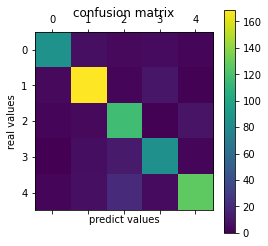

In [35]:
#vgg19
print('confusion_matrix :')
print(confusion_matrix)
plt.matshow(confusion_matrix)
plt.title("confusion matrix")
plt.colorbar()
plt.ylabel("real values")
plt.xlabel("predict values")
plt.show()

In [53]:
print(classification_report(a,b))


              precision    recall  f1-score   support

           0       0.89      0.81      0.85       105
           1       0.88      0.90      0.89       186
           2       0.75      0.88      0.81       133
           3       0.81      0.83      0.82       105
           4       0.91      0.78      0.84       162

    accuracy                           0.85       691
   macro avg       0.85      0.84      0.84       691
weighted avg       0.85      0.85      0.85       691



#### densnet161

In [36]:
model = densenet161

running_corrects_val = 0.0
device= torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
labels_val_list = []
pred_val_list = []

for inputs_val, labels_val in loaders['val']:
  inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
  outp_val = model(inputs_val)
  _, pred_val = torch.max(outp_val, 1)
  running_corrects_val += torch.sum(pred_val == labels_val.data)
  labels_val_list.append(labels_val)
  pred_val_list.append(pred_val)

acc = 100. * running_corrects_val / dataset_sizes['val']
epoch_acc = running_corrects_val/dataset_sizes['val']

a = []
b = []
for key in labels_val_list:
  a += key.cpu().tolist()
for key in pred_val_list:
  b += key.cpu().tolist()

confusion_matrix = confusion_matrix(a,b)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.  cpuset_checked))


confusion_matrix :
[[ 91   4   4   4   2],
 [  1 173   2   7   3],
 [  1   3 121   2   7],
 [  2   2   4  96   1],
 [  2   4  16   4 136]]


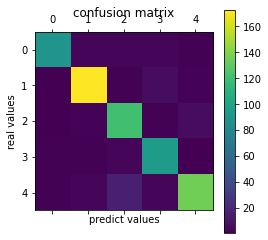

In [62]:
#densnet
print('confusion_matrix :')
print(confusion_matrix)
plt.matshow(confusion_matrix)
plt.title("confusion matrix")
plt.colorbar()
plt.ylabel("real values")
plt.xlabel("predict values")
plt.show()

In [63]:
print(classification_report(a,b))


              precision    recall  f1-score   support

           0       0.95      0.87      0.88       105
           1       0.93      0.93      0.91       186
           2       0.85      0.91      0.86       133
           3       0.88      0.91      0.88       105
           4       0.92      0.84      0.86       162

    accuracy                           0.88       691
   macro avg       0.91      0.90      0.89       691
weighted avg       0.91      0.91      0.88       691



#### squeezenet

In [37]:
model = squeezenet1_0

running_corrects_val = 0.0
device= torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
labels_val_list = []
pred_val_list = []

for inputs_val, labels_val in loaders['val']:
  inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
  outp_val = model(inputs_val)
  _, pred_val = torch.max(outp_val, 1)
  running_corrects_val += torch.sum(pred_val == labels_val.data)
  labels_val_list.append(labels_val)
  pred_val_list.append(pred_val)

acc = 100. * running_corrects_val / dataset_sizes['val']
epoch_acc = running_corrects_val/dataset_sizes['val']

a = []
b = []
for key in labels_val_list:
  a += key.cpu().tolist()
for key in pred_val_list:
  b += key.cpu().tolist()

confusion_matrix = confusion_matrix(a,b)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.  cpuset_checked))


confusion_matrix :
[[ 88   7   4   4   2],
 [  0 169   2  11   4],
 [  5   1 117   2   8],
 [  1   5   9  89   1],
 [  1   5  21   8 127]]


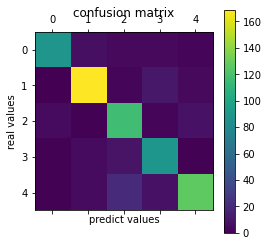

In [45]:
#vgg19
print('confusion_matrix :')
print(confusion_matrix)
plt.matshow(confusion_matrix)
plt.title("confusion matrix")
plt.colorbar()
plt.ylabel("real values")
plt.xlabel("predict values")
plt.show()

In [58]:
print(classification_report(a,b))


              precision    recall  f1-score   support

           0       0.93      0.87      0.88       105
           1       0.90      0.93      0.91       186
           2       0.82      0.90      0.85       133
           3       0.83      0.89      0.86       105
           4       0.93      0.79      0.86       162

    accuracy                           0.87       691
   macro avg       0.88      0.87      0.86       691
weighted avg       0.88      0.88      0.87       691



#### resnet152

In [38]:
model = resnet152

running_corrects_val = 0.0
device= torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
labels_val_list = []
pred_val_list = []

for inputs_val, labels_val in loaders['val']:
  inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
  outp_val = model(inputs_val)
  _, pred_val = torch.max(outp_val, 1)
  running_corrects_val += torch.sum(pred_val == labels_val.data)
  labels_val_list.append(labels_val)
  pred_val_list.append(pred_val)

acc = 100. * running_corrects_val / dataset_sizes['val']
epoch_acc = running_corrects_val/dataset_sizes['val']

a = []
b = []
for key in labels_val_list:
  a += key.cpu().tolist()
for key in pred_val_list:
  b += key.cpu().tolist()

confusion_matrix = confusion_matrix(a,b)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.  cpuset_checked))


confusion_matrix :
[[ 86   7   2   5   5],
 [  3 170   1  11   1],
 [  3   2 115   2  11],
 [  0   6   9  89   1],
 [  4   6  20   5 127]]


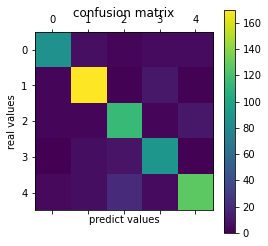

In [48]:
#resnet152
print('confusion_matrix :')
print(confusion_matrix)
plt.matshow(confusion_matrix)
plt.title("confusion matrix")
plt.colorbar()
plt.ylabel("real values")
plt.xlabel("predict values")
plt.show()

In [56]:
print(classification_report(a,b))


              precision    recall  f1-score   support

           0       0.92      0.86      0.87       105
           1       0.91      0.92      0.90       186
           2       0.79      0.89      0.84       133
           3       0.81      0.88      0.85       105
           4       0.91      0.79      0.85       162

    accuracy                           0.86       691
   macro avg       0.87      0.86      0.85       691
weighted avg       0.87      0.87      0.86       691



#### analysis

Based on the four trained models and their index values, it can be determined that the data labeled 2 and 5, namely rose and tulip,  are easily misclassified.



The data labeled 4, namely tulip, has the highest accuracy

As for the accuracies between four models, it is obvious that densnet161 has the highest accurancy about 0.91, but the higher accuracy, the longer time that it needs.

### kaggle test

In [ ]:
model_list = [(vgg19_bn,'vgg19_bn'),(densenet161,'densenet161'),(squeezenet1_0,'squeezenet1_0'),(resnet152,'resnet152')]

p = []
path = "/content/drive/MyDrive/22WINTER/596A/HW5/flower_test_uplevel/flower_test_new"
files = os.listdir(path)

for (model,modelname) in model_list:
  device= torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  model.to(device)
  pred_test_list = []
  name = []
  for key in files: 
    img = Image.open(path + '/'+ key) 
    inp_test = simple_transform(img)
    e = torch.unsqueeze(inp_test, 0)
    e = e.to(device)
    outp_test = model(e)
    _, pred_test = torch.max(outp_test, 1)
    pred_test_list.append(pred_test)
    name.append(key)

  q = []
  for key in pred_test_list:
    q += key.tolist()
  flowername = []
  for key in q:
    if key == 0: flowername.append('daisy')
    elif key == 1: flowername.append('dandelion')
    elif key == 2: flowername.append('rose')
    elif key == 3 : flowername.append('sunflower')
    elif key == 4: flowername.append('tulip')

  out = pd.DataFrame(columns = ['Id','Category'])
  out['Id'] = name
  out['Category'] = p

  out.to_csv((modelname+'.csv'))

result:

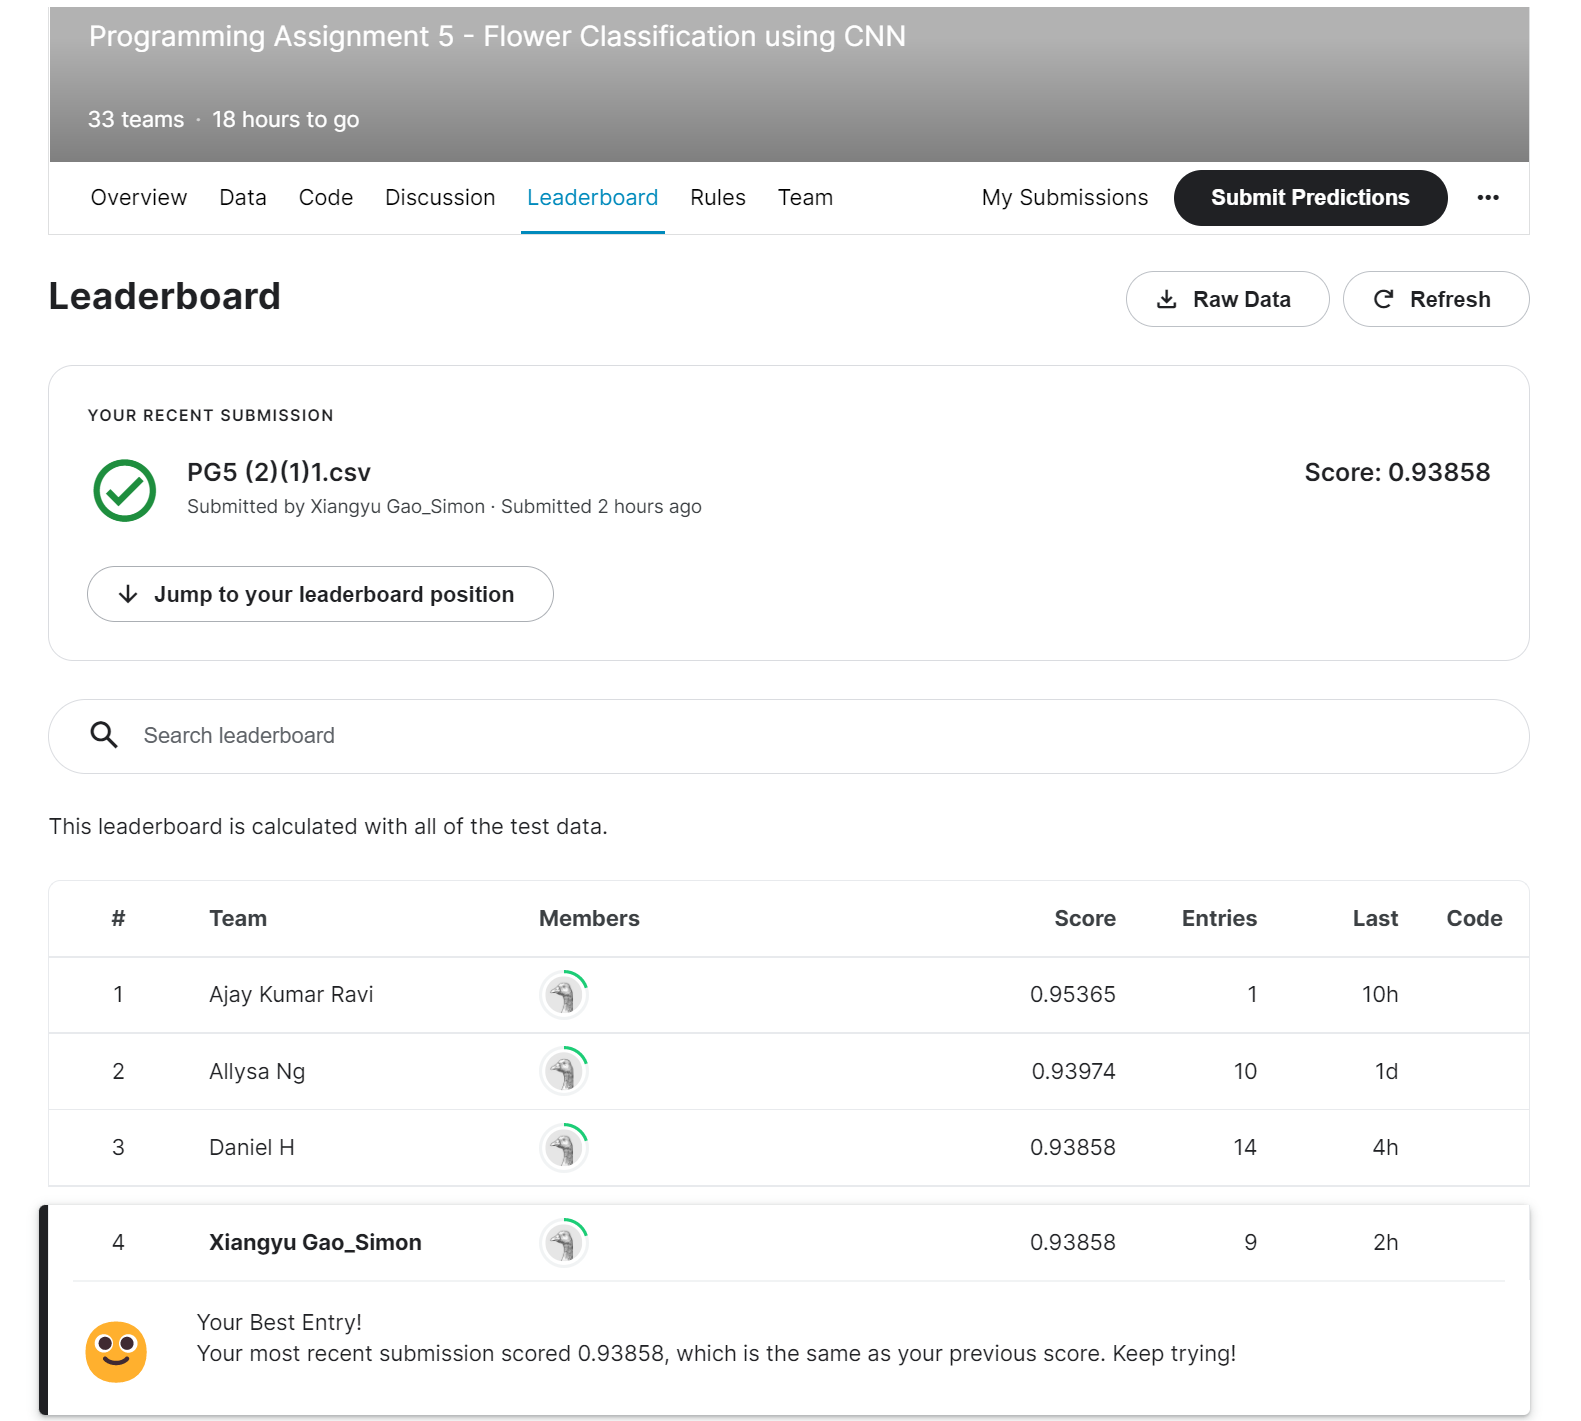